# Note
Use a GPU to run this notebook

# Install and import requirements

In [1]:
%cd /content/drive/MyDrive/Github/Idoven
!pip install -qq -U -r requirements.txt
import numpy
import pandas
import ast
import copy 
import matplotlib.pyplot
import seaborn
import torch
import utils

/content/drive/MyDrive/Github/Idoven
     |████████████████████████████████| 13.1 MB 19.2 MB/s 
     |████████████████████████████████| 288 kB 59.8 MB/s 
     |████████████████████████████████| 161 kB 5.2 MB/s 
     |████████████████████████████████| 137 kB 65.6 MB/s 
     |████████████████████████████████| 137 kB 55.8 MB/s 


# Configure some parameters

In [2]:
path = 'physionet.org/files/ptb-xl/1.0.2/'
%matplotlib inline
seaborn.set(style='whitegrid', palette='Set2', font_scale=1.5)
matplotlib.pyplot.rcParams['figure.figsize'] = (10, 5)
matplotlib.pyplot.rcParams['figure.dpi'] = 100

RANDOM_SEED = 42
numpy.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Alert whether a 12-lead ECG-waveform is deviated from normal behavior
Let's use the lead I and a LSTM Autoencoder to reconstruct a 12-lead ECG as best as possible by capturing the most important features of a NORMAL 12-lead ECG. Because of the LSTM layers, the temporal dependencies have been kept in mind. 

## Data

In [3]:
data_ptbxl = pandas.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
data_ptbxl.r_peaks = data_ptbxl.r_peaks.apply(lambda x: list(map(int, x.replace('[', '').replace(']', '').split())))
data_ptbxl.scp_codes = data_ptbxl.scp_codes.apply(lambda x: ast.literal_eval(x))
data_scp = pandas.read_csv(path + 'scp_statements.csv', index_col=0)
data_scp = data_scp[data_scp.diagnostic == 1]
data_ptbxl['diagnostic_superclass'] = data_ptbxl.scp_codes.apply(lambda x: utils.aggregate_superclasses(x, data_scp))
data_ptbxl = (data_ptbxl
              .loc[data_ptbxl.diagnostic_superclass.apply(len) != 0, :]
              .explode(['diagnostic_superclass'])
              )
data_ptbxl['binary_diagnostic_superclass'] = (data_ptbxl.diagnostic_superclass
                                              .apply(lambda x: 'ANOMALY' if x in ['CD', 'HYP', 'MI', 'STTC'] else 'NORMAL'))

In [4]:
def ECGs_for_model(signal: numpy.array):
  signal = torch.from_numpy(signal)
  if device == "cuda":
    signal = signal.type(torch.cuda.FloatTensor)
  else:
    signal = signal.type(torch.FloatTensor)
  n_sample, n_length, n_features = signal.shape
  return signal, n_length, n_features

In [12]:
ECGs = utils.load_ECGs(mode='training', superclass='NORMAL', data=data_ptbxl, n=5000)
training_dataset, n_length, _ = ECGs_for_model(ECGs)
print(training_dataset.shape)

ECGs = utils.load_ECGs(mode='validation', superclass='NORMAL', data=data_ptbxl, n=2000)
validation_dataset, _, _ = ECGs_for_model(ECGs)
print(validation_dataset.shape)

ECGs = utils.load_ECGs(mode='test', superclass='NORMAL', data=data_ptbxl, n=1000)
test_normal_dataset, _, _ = ECGs_for_model(ECGs)

print(test_normal_dataset.shape)
ECGs = utils.load_ECGs(mode='test', superclass='ANOMALY', data=data_ptbxl, n=1000)
test_anomaly_dataset, _, _ = ECGs_for_model(ECGs)
print(test_anomaly_dataset.shape)

torch.Size([5000, 1000, 12])
torch.Size([956, 1000, 12])
torch.Size([963, 1000, 12])
torch.Size([1000, 1000, 12])


## Model

### Disclaimer
Don't use it. It is just a proof of concept

In [14]:
class Encoder(torch.nn.Module):

  def __init__(self, n_length: int, hidden_size: int):
    super(Encoder, self).__init__()

    self.n_length = n_length
    self.hidden_size = hidden_size

    self.lstm_1 = torch.nn.LSTM(
      input_size=1,
      hidden_size=(2 ** 1) * self.hidden_size,
      num_layers=1,
      batch_first=True
    )

    self.lstm_2 = torch.nn.LSTM(
      input_size=(2 ** 1) * self.hidden_size,
      hidden_size=self.hidden_size,
      num_layers=1,
      batch_first=True
    )
    
  def forward(self, x):
    x = x.reshape((1, self.n_length, 1))
    x, (_, _) = self.lstm_1(x)
    _, (hidden, _) = self.lstm_2(x)
    hidden = hidden.reshape((1, self.hidden_size))
    return hidden

In [15]:
class Decoder(torch.nn.Module):

  def __init__(self, n_length: int, input_size: int):
    super(Decoder, self).__init__()

    self.n_length = n_length
    self.input_size = input_size

    self.lstm_1 = torch.nn.LSTM(
      input_size=self.input_size,
      hidden_size=(2 ** 1) * self.input_size,
      num_layers=1,
      batch_first=True
    )

    self.lstm_2 = torch.nn.LSTM(
      input_size=(2 ** 1) * self.input_size,
      hidden_size=(2 ** 2) * self.input_size,
      num_layers=1,
      batch_first=True
    )

    self.linear = torch.nn.Linear((2 ** 2) * self.input_size, 1)

  def forward(self, x):
    x = x.repeat(self.n_length, 1)
    x = x.reshape((1, self.n_length, self.input_size))
    x, (_, _) = self.lstm_1(x)
    x, (_, _) = self.lstm_2(x) 
    x = x.reshape((self.n_length, (2 ** 2) * self.input_size))
    x = self.linear(x)
    return x

In [16]:
class LSTMAutoencoder(torch.nn.Module):

  def __init__(self, n_length: int, hidden_size: int):
    super(LSTMAutoencoder, self).__init__()

    self.encoder = Encoder(n_length, hidden_size).to(device)
    self.decoder = Decoder(n_length, hidden_size).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

### Training

In [17]:
def train_model(model: torch.nn.Module, train_dataset: torch.tensor, val_dataset: torch.tensor, n_epochs: int):
  
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  history = dict(training=[], validation=[])
  best_model_weights = copy.deepcopy(model.state_dict())
  best_loss = 100000.0
  
  for epoch in range(1, n_epochs + 1):
    
    model = model.train()
    train_losses = []

    for ECG in train_dataset:
    
      optimizer.zero_grad()
      ECG = ECG.to(device)
      ECG_pred = model(ECG)
      loss = criterion(ECG_pred, ECG)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())

    model = model.eval()
    val_losses = []
    with torch.no_grad():

      for ECG in val_dataset:

        ECG = ECG.to(device)
        ECG_pred = model(ECG)
        loss = criterion(ECG_pred, ECG)
        val_losses.append(loss.item())

    train_loss = numpy.mean(train_losses)
    val_loss = numpy.mean(val_losses)
    history['training'].append(train_loss)
    history['validation'].append(val_loss)

    if val_loss < best_loss:

      best_loss = val_loss
      best_model_weights = copy.deepcopy(model.state_dict())
      print("Model updated")
      torch.save(model, 'model.pth')

    print(f'Epoch {epoch}: training loss {train_loss} validation loss {val_loss}')

  model.load_state_dict(best_model_weights)
  return model.eval(), history

In [20]:
model = LSTMAutoencoder(n_length=n_length, hidden_size=64)
model = model.to(device)

In [21]:
model, history = train_model(
    model, 
    training_dataset[:, :, 0], # lead I
    validation_dataset[:, :, 0], # lead I
    n_epochs=10
    );

Model updated
Epoch 1: training loss 75908.40771835938 validation loss 74531.1482536284
Model updated
Epoch 2: training loss 75812.46668710938 validation loss 74531.01991942337
Model updated
Epoch 3: training loss 75806.5173609375 validation loss 74530.71144008238
Epoch 4: training loss 75804.130896875 validation loss 74530.76503048182
Epoch 5: training loss 75802.19007460937 validation loss 74531.21688472477
Epoch 6: training loss 75804.75413945313 validation loss 76851.35255540664
Model updated
Epoch 7: training loss 76274.952003125 validation loss 74526.23943964108
Epoch 8: training loss 75803.8253796875 validation loss 74530.83444201098
Epoch 9: training loss 75800.52805351562 validation loss 74531.03352592181
Epoch 10: training loss 75800.53885351562 validation loss 74530.84603613689


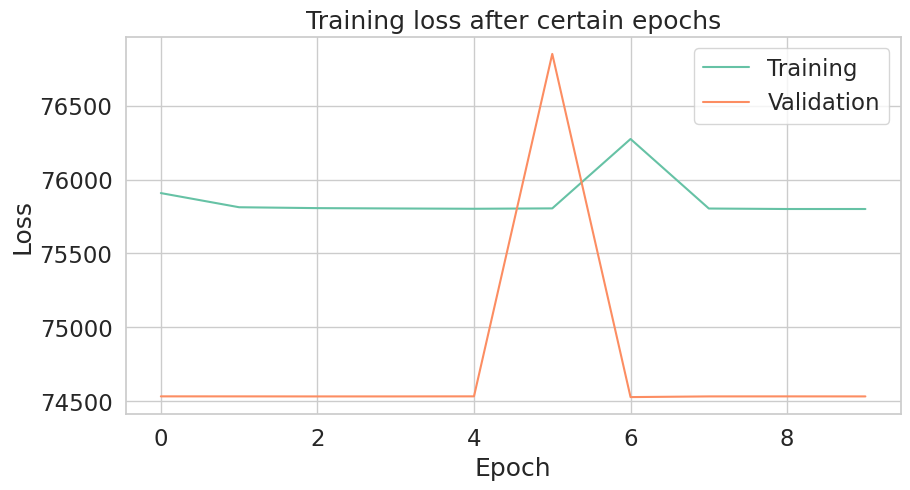

In [22]:
ax = matplotlib.pyplot.figure().gca()
ax.plot(history['training'])
ax.plot(history['validation'])
matplotlib.pyplot.ylabel('Loss')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.legend(['Training', 'Validation'])
matplotlib.pyplot.title('Training loss after certain epochs')
matplotlib.pyplot.show();

### Choose the optimal reconstruction loss threshold

It is the one with the lowest rate of false positives and negatives. A 12-lead ECG will be classified as NORMAL if the reconstruction loss is below the threshold.

In [23]:
# MODEL_PATH = 'model.pth'
# model = torch.load(MODEL_PATH)
# model = model.to(device)

In [24]:
def predict(model: torch.nn.Module, dataset: torch.tensor):
  
  predictions, losses = [], []
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  
  with torch.no_grad():
    
    model = model.eval()

    for ECG in dataset:
    
      ECG = ECG.to(device)
      ECG_pred = model(ECG)
      loss = criterion(ECG_pred, ECG)
      predictions.append(ECG_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  
  return predictions, losses

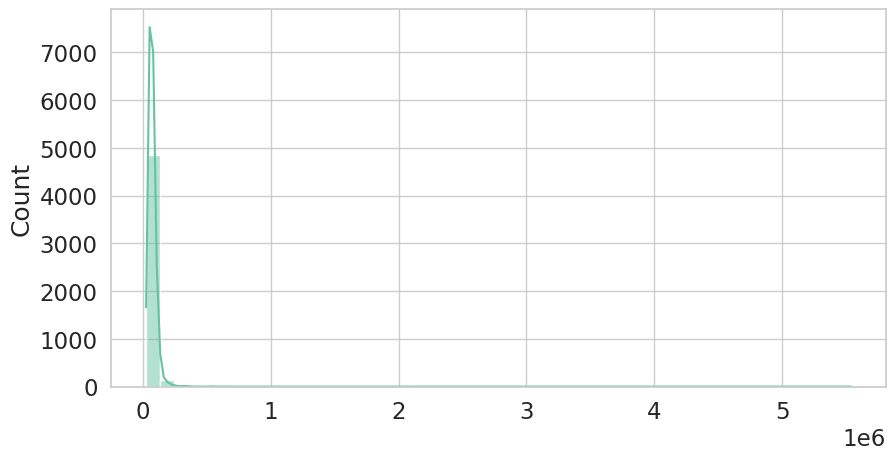

In [25]:
_, losses = predict(model, training_dataset[:, :, 0])
seaborn.histplot(losses, bins=50, kde=True);

### Evaluation

In [34]:
THRESHOLD = 75000

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


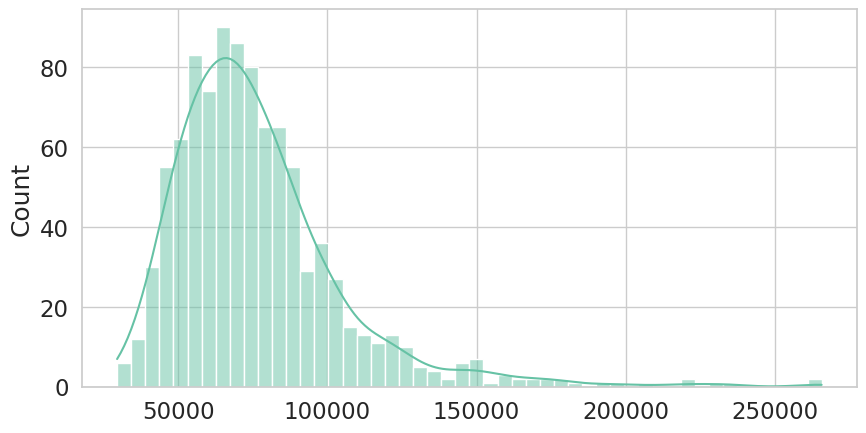

In [35]:
predictions, pred_losses = predict(model, test_normal_dataset[:, :, 0]);
seaborn.histplot(pred_losses, bins=50, kde=True);

In [36]:
correct = sum(l <= THRESHOLD for l in pred_losses)
n = len(test_normal_dataset)
print(f'Correct NORMAL ECG predictions / Total NORMAL ECGs: {correct}/{n} ({round(100*correct/n, 2)}%)')

Correct NORMAL ECG predictions / Total NORMAL ECGs: 547/963 (56.8%)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


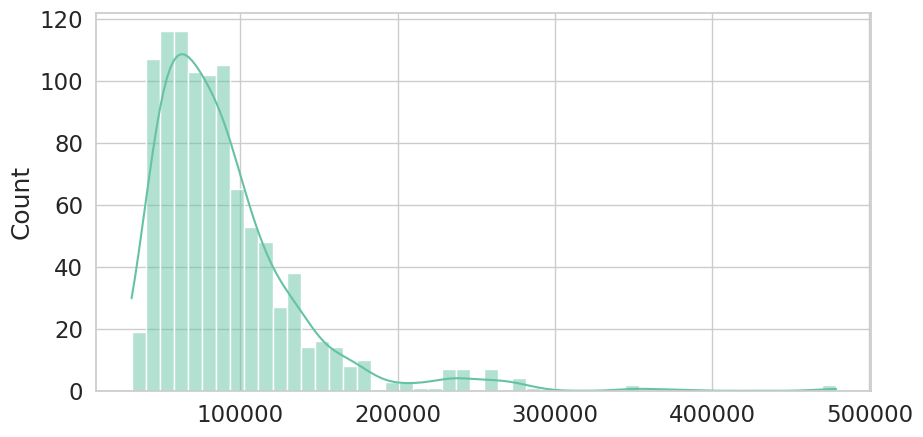

In [37]:
predictions, pred_losses = predict(model, test_anomaly_dataset[:, :, 0]);
seaborn.histplot(pred_losses, bins=50, kde=True);

In [38]:
correct = sum(l > THRESHOLD for l in pred_losses)
n = len(test_anomaly_dataset)
print(f'Correct ANOMALY ECG predictions / Total ANOMALY ECGs: {correct}/{n} ({round(100*correct/n, 2)}%)')

Correct ANOMALY ECG predictions / Total ANOMALY ECGs: 546/1000 (54.6%)


In [39]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])
  ax.plot(data, label='ECG')
  ax.plot(predictions[0], label='Reconstruction')
  ax.set_title(f'{title} (loss: {numpy.around(pred_losses[0], 2)})')
  ax.legend()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(inp

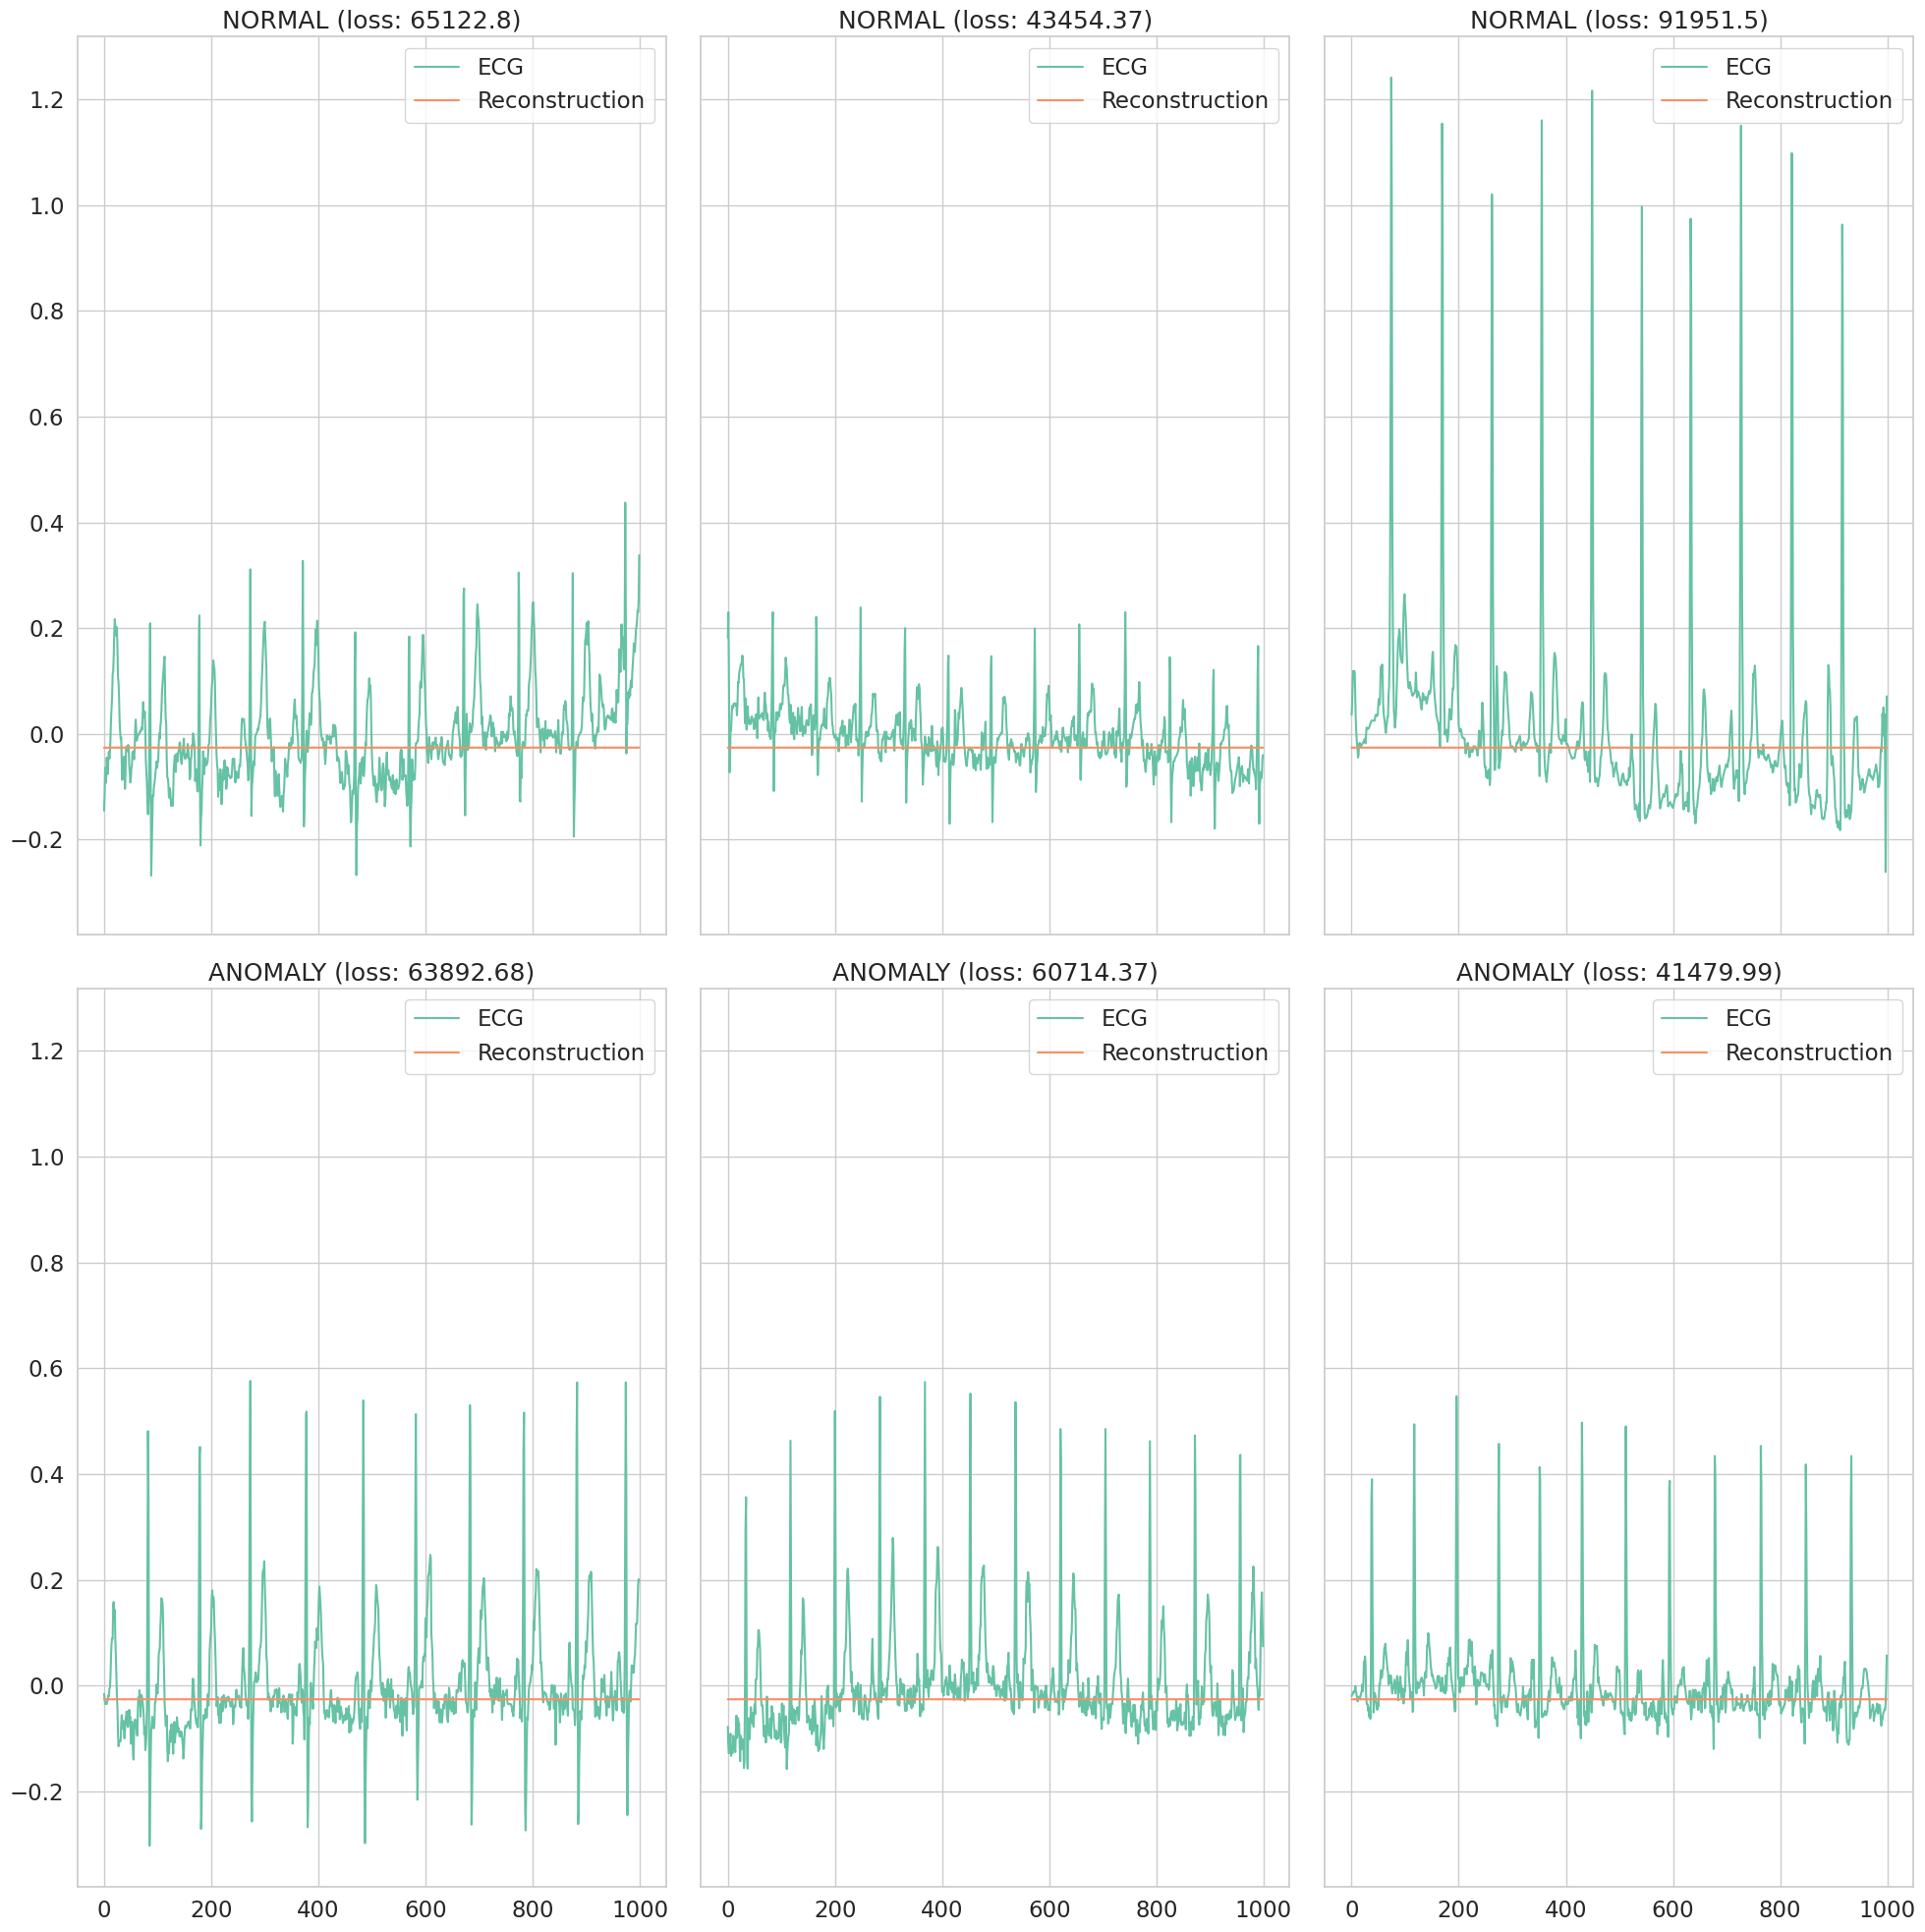

In [41]:
fig, axs = matplotlib.pyplot.subplots(
  nrows=2,
  ncols=3,
  sharey=True,
  sharex=True,
  figsize=(20, 20)
)

for i, data in enumerate(test_normal_dataset[:3, :, 0]):
  plot_prediction(data, model, title='NORMAL', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:3, :, 0]):
  plot_prediction(data, model, title='ANOMALY', ax=axs[1, i])

fig.tight_layout();

### Conclusion
This model doesn't produce good results as we see in the learning curves (training loss versus validation loss) but we can see more clearly in the plots from evaluation. So, the next step should be:

*   normalize ECG signal data
*   rebuild part or all of the model architecture (if the tuning of the model's hyperparameters don't produce good results again)